In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
old_amh_words=open("data/new_amahric.txt","r").read().splitlines()
cleaned_amh=[word.strip() for word in old_amh_words]
with open('cleaned_words.txt', 'w') as f:
    for word in cleaned_amh:
        f.write(word + '\n')

In [3]:
new_words=pd.read_csv("data/amharic_names.csv")
old_words=open("data/cleaned_words.txt","r").read().splitlines()
new_amh_words=new_words["in_am"].tolist()
am_words=new_amh_words + old_words

In [57]:
chrs=sorted(set(list("".join(am_words))))
stoi={s:i+1 for i,s in enumerate(chrs)}
stoi["."]=0
itos={i:s for s,i in stoi.items()}
itos

{1: 'ሀ',
 2: 'ሁ',
 3: 'ሂ',
 4: 'ሃ',
 5: 'ሄ',
 6: 'ህ',
 7: 'ሆ',
 8: 'ለ',
 9: 'ሉ',
 10: 'ሊ',
 11: 'ላ',
 12: 'ሌ',
 13: 'ል',
 14: 'ሎ',
 15: 'ሐ',
 16: 'ሑ',
 17: 'ሒ',
 18: 'ሓ',
 19: 'ሔ',
 20: 'ሕ',
 21: 'ሖ',
 22: 'መ',
 23: 'ሙ',
 24: 'ሚ',
 25: 'ማ',
 26: 'ሜ',
 27: 'ም',
 28: 'ሞ',
 29: 'ሟ',
 30: 'ሠ',
 31: 'ሡ',
 32: 'ሢ',
 33: 'ሣ',
 34: 'ሥ',
 35: 'ሦ',
 36: 'ረ',
 37: 'ሩ',
 38: 'ሪ',
 39: 'ራ',
 40: 'ሬ',
 41: 'ር',
 42: 'ሮ',
 43: 'ሰ',
 44: 'ሱ',
 45: 'ሲ',
 46: 'ሳ',
 47: 'ሴ',
 48: 'ስ',
 49: 'ሶ',
 50: 'ሸ',
 51: 'ሹ',
 52: 'ሺ',
 53: 'ሻ',
 54: 'ሼ',
 55: 'ሽ',
 56: 'ሾ',
 57: 'ቀ',
 58: 'ቁ',
 59: 'ቂ',
 60: 'ቃ',
 61: 'ቄ',
 62: 'ቅ',
 63: 'ቆ',
 64: 'በ',
 65: 'ቡ',
 66: 'ቢ',
 67: 'ባ',
 68: 'ቤ',
 69: 'ብ',
 70: 'ቦ',
 71: 'ቨ',
 72: 'ቪ',
 73: 'ቫ',
 74: 'ቮ',
 75: 'ተ',
 76: 'ቱ',
 77: 'ቲ',
 78: 'ታ',
 79: 'ቴ',
 80: 'ት',
 81: 'ቶ',
 82: 'ቸ',
 83: 'ቹ',
 84: 'ቺ',
 85: 'ቻ',
 86: 'ቼ',
 87: 'ች',
 88: 'ቾ',
 89: 'ኀ',
 90: 'ኂ',
 91: 'ኃ',
 92: 'ኅ',
 93: 'ነ',
 94: 'ኑ',
 95: 'ኒ',
 96: 'ና',
 97: 'ኔ',
 98: 'ን',
 99: 'ኖ',
 100: 'ኘ',
 101: 'ኛ

In [58]:
block_size=3

def build_dataset(am_words):
    X,Y=[],[]
    for w in am_words:
        context=[0]*block_size
        for ch in w +".":
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix]
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(am_words)
n1=int(0.8*(len(am_words)))
n2=int(0.9*(len(am_words)))

Xtr,Ytr=build_dataset(am_words[:n1])      #80
Xval,Yval=build_dataset(am_words[n1:n2])  #10
Xte,Yte=build_dataset(am_words[n2:])      #10

In [63]:
n_embed=10  # dimensionality of the char embedding vector
n_hidden=200
vocab_size=len(itos)

g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,n_embed), generator=g)
W1=torch.randn((n_embed*block_size,n_hidden), generator=g)
b1=torch.randn(n_hidden, generator=g)
W2=torch.randn((n_hidden,vocab_size), generator=g) * 0.01
b2=torch.randn(vocab_size, generator=g)           *0
parameters=[C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

49877


In [64]:
max_step=200000
batch_size=32
lossi=[]

for i in range(max_step):

    #minibatch
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix]

    #forward pass
    embed=C[Xb]   #embed the char into vectors
    embed_cat=embed.view(embed.shape[0],-1) 
    hid_preact=embed_cat@W1+b1    #hidden layer
    h=torch.tanh(hid_preact)  #hidden layer
    logits=h@W2+b2 #output layer
    loss=F.cross_entropy(logits,Yb)

    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #update
    lr=0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
    
    #track stats
    if i%1000==0:
        print(f"{i:7d}/{max_step:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 5.3615
   1000/ 200000: 3.1768
   2000/ 200000: 2.8265
   3000/ 200000: 3.2271
   4000/ 200000: 2.8410
   5000/ 200000: 2.6481
   6000/ 200000: 2.3684
   7000/ 200000: 3.0709
   8000/ 200000: 2.4839
   9000/ 200000: 2.4061
  10000/ 200000: 2.6825
  11000/ 200000: 1.7045
  12000/ 200000: 2.4367
  13000/ 200000: 2.1315
  14000/ 200000: 2.2584
  15000/ 200000: 2.0740
  16000/ 200000: 1.4300
  17000/ 200000: 1.9660
  18000/ 200000: 2.6590
  19000/ 200000: 1.6854
  20000/ 200000: 2.8765
  21000/ 200000: 2.2280
  22000/ 200000: 1.4352
  23000/ 200000: 1.6677
  24000/ 200000: 1.9969
  25000/ 200000: 1.5431
  26000/ 200000: 1.4784
  27000/ 200000: 1.4779
  28000/ 200000: 1.0912
  29000/ 200000: 2.0620
  30000/ 200000: 1.9421
  31000/ 200000: 1.8470
  32000/ 200000: 1.1099
  33000/ 200000: 1.7142
  34000/ 200000: 2.0547
  35000/ 200000: 1.5217
  36000/ 200000: 1.4387
  37000/ 200000: 1.7540
  38000/ 200000: 1.5899
  39000/ 200000: 1.6988
  40000/ 200000: 1.6407
  41000/ 200000:

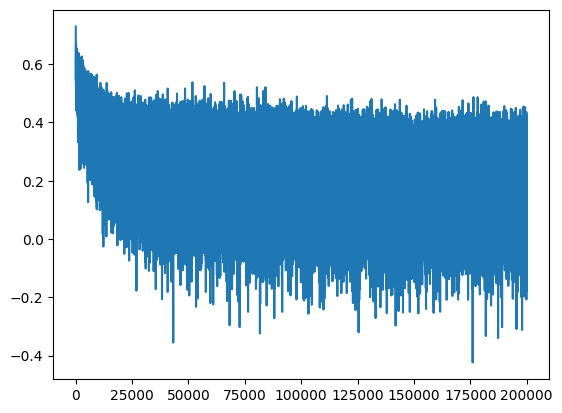

In [65]:
plt.plot(lossi)

In [66]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
    }[split]    
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.6318507194519043
val 6.028583526611328


- as you can see the validation loss is higher than the train loss this show us our model is overfitting.

In [123]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

ሰበንያ.
አንድነት.
አስሮን.
ዩላ.
ደራል.
ሳኦል.
አክሱም.
ጥህ.
ኤንያ.
አማፌችትቤት.
ሰለሚኤል.
ሐማን.
ኤላ.
ጵርቅላ.
ቅልዓ.
ሳስታውለሓ.
ነሩስሳኬል.
ይይድዊን.
አኦራ.
ጥበቡ.
